In [1]:
import os

os.environ[
    "OMP_NUM_THREADS"
] = "64"  # for jupyter.nersc.gov otherwise the notebook only uses 2 cores

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rc('image', cmap='coolwarm')

import seaborn as sns

sns.set_context("talk")
# sns.set()
sns.set_style("ticks")

import numpy as np
import healpy as hp

import logging
log = logging.getLogger("healpy")
log.setLevel(logging.ERROR)

import time 

from ForSEplus.my_forse_class import forse_my
from ForSEplus.utility import rescale_input, correct_EB, from_12toXX
from ForSEplus.recompose_class import recom
from ForSEplus.after_training_12amin import post_training as post_training_12
from ForSEplus.after_training_3amin import post_training as post_training_3

import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
for g in range(len(physical_devices)):
    tf.config.experimental.set_memory_growth(physical_devices[g], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [17]:
import importlib
import ForSEplus

In [45]:
importlib.reload(ForSEplus.utility)

<module 'ForSEplus.utility' from '/global/u2/j/jianyao/ForSEplus_github/src/ForSEplus/utility.py'>

In [2]:
import psutil
import sys
import tracemalloc
import linecache

In [4]:
tracemalloc.start()

In [5]:
dir_data = '/pscratch/sd/j/jianyao/ForSE_plus_data/'

ss_I = np.load(dir_data + 'maps_cls/GNILC_Thr12_Qlr80_20x20deg_Npix320_full_sky_adaptive.npy', allow_pickle=True)[0, 0:348]

Ls_Q80amin = np.load(dir_data + 'maps_cls/GNILC_Thr12_Qlr80_20x20deg_Npix320_full_sky_adaptive.npy', allow_pickle=True)[1, 0:174]*1e6
Ls_U80amin = np.load(dir_data + 'maps_cls/GNILC_Thr12_Ulr80_20x20deg_Npix320_full_sky_adaptive.npy', allow_pickle=True)[1, 0:174]*1e6

gauss_ss_ps_12 = np.load(dir_data + 'maps_cls/gauss_small_scales_12_over_80_power_spectra.npy') #[2, 174, 49, 1, 25] Q, U
gauss_ss_mean_std_12 = np.load(dir_data + 'maps_cls/gauss_small_scales_12_over_80_mean_and_std.npy') #[4, 174, 49] Q_mean, Q_std, U_mean, U_std

gauss_ss_ps_3 = np.load(dir_data + 'maps_cls/gauss_small_scales_3_over_20_power_spectra_lmax_3500.npy') #[2, 174, 49, 1, 25] Q, U
gauss_ss_mean_std_3 = np.load(dir_data + 'maps_cls/gauss_small_scales_3_over_20_mean_and_std.npy') #[4, 174, 49] Q_mean, Q_std, U_mean, U_std

ori_train_Q = np.load(dir_data + 'maps_cls/GNILC_Thr12_Qlr80_20x20deg_Npix320_full_sky_adaptive.npy')[1, 0:174]
ori_train_U = np.load(dir_data + 'maps_cls/GNILC_Thr12_Ulr80_20x20deg_Npix320_full_sky_adaptive.npy')[1, 0:174]

model_Q_12amin = dir_data + 'models/model_all_h5_snr_1_Q11'
model_U_12amin = dir_data + 'models/model_all_h5_snr_1_U12'

model_Q_3amin =  dir_data + 'models/model_3amin_696_patches_Q85'
model_U_3amin =  dir_data + 'models/model_3amin_696_patches_U396'

start = time.time()
print('Loading models')
model_Q = tf.keras.models.load_model(model_Q_12amin)
model_U = tf.keras.models.load_model(model_U_12amin)

model_Q_3 = tf.keras.models.load_model(model_Q_3amin)
model_U_3 = tf.keras.models.load_model(model_U_3amin)

print('Initialize the recomposing class')
recom_3 = recom(npix = 1280, pixelsize = 0.937, overlap = 2, nside = 4096, 
                 apodization_file = dir_data + 'masks/mask_1280_1280.npy', 
                 xy_inds_file = dir_data + 'geometry/recompose_xinds_yinds_4096', 
                 index_sphere_file = dir_data + 'geometry/recompose_footprint_healpix_index_4096', verbose=False)

print('Load maps at 80amin')
Ls_Q = ori_train_Q.copy()
Ls_U = ori_train_U.copy()

print('Generating input random noise with model SNR = %s...'%1)
# np.random.seed(2048)

verbose = True

for i in range(0, 1):
    
    if verbose == True:
        print('12amin Generating patches...')

    NNout_Q_12 = model_Q.predict(rescale_input([Ls_Q], random_noise = [np.random.uniform(-1, 1, (174, 320, 320)).astype(np.float32)]))
    NNout_U_12 = model_U.predict(rescale_input([Ls_U], random_noise = [np.random.uniform(-1, 1, (174, 320, 320)).astype(np.float32)]))

    if verbose == True:
        print('12amin: Renormalize patches...')
    output12 = post_training_12(NNout_Q_12[:,:,:,0] , NNout_U_12[:,:,:,0], ss_I, Ls_Q80amin, Ls_U80amin, MF = False)
    save_dir_12 = '/pscratch/sd/j/jianyao/forse_output/Random_training_files/FIX_MF/Complete/12amin_norm/'
    norm_Q12amin = 'NN_out_Q_12amin_from_12amin_physical_units_20x20_320_%03d.npy'%(i)
    norm_U12amin = 'NN_out_U_12amin_from_12amin_physical_units_20x20_320_%03d.npy'%(i)
        
    output12.normalization(gauss_ss_ps_12, gauss_ss_mean_std_12, mask_path = dir_data + 'masks/mask_320x320.npy')
                           # save_path = [save_dir_12 + norm_Q12amin, save_dir_12 + norm_U12amin])

    # output12.plot_MF()
        # dir_12 = '/pscratch/sd/j/jianyao/forse_output/Random_training_files/FIX_MF/2_random_12amin_renormalized/New_realizations_1/'
        # NNmapQ_corr = np.load(dir_12 + 'Random_1_testing_data_Nico_T12amin_1_Q80amin_renormalized_000.npy')
        # NNmapU_corr = np.load(dir_12 + 'Random_1_testing_data_Nico_T12amin_1_U80amin_renormalized_000.npy')
    
    if verbose == True:
        print('3 amin: construct input 20amin and normalizing-13amin maps')
    
    # del output12

    if verbose == True:
        print('3amin: Generating patches...')
        
    # 6.5G # 6.5G
    NNout_Q = model_Q_3.predict(rescale_input([from_12toXX(output12.NNmapQ_corr, XX = 20)], random_noise = [np.random.uniform(-1, 1, (174*49, 320, 320)).astype(np.float32)]))
    NNout_U = model_U_3.predict(rescale_input([from_12toXX(output12.NNmapU_corr, XX = 20)], random_noise = [np.random.uniform(-1, 1, (174*49, 320, 320)).astype(np.float32)]))

    if verbose == True:
        print('3amin: renormalize patches ...')
    output3 = post_training_3(NNout_Q, NNout_U, ss_I, MF = True)
    output3.normalization(gauss_ss_ps_3, gauss_ss_mean_std_3, output12.NNmapQ_corr, output12.NNmapU_corr, 
                          mask_path = dir_data + 'masks/mask_320x320.npy')
    
    norm_Q3amin = 'NN_out_Q_3amin_from_20amin_physical_units_20x20_1280_%03d.npy'%(i)
    norm_U3amin = 'NN_out_U_3amin_from_20amin_physical_units_20x20_1280_%03d.npy'%(i)
    save_dir_3 = '/pscratch/sd/j/jianyao/forse_output/Random_training_files/FIX_MF/Complete/3amin_norm/'
    output3.combine_to_20by20(output3.NNmapQ_corr, output3.NNmapU_corr, maps = 'ss_norm')
    # output3.combine_to_20by20(NNout_Q.reshape(174,49,320,320), NNout_U.reshape(174,49,320,320), maps = 'ss')
    # test = output3.plot_MF(patch_N = 3, savedir=False)

    if verbose == True:
        print('3amin: reproject to full sky ...')
    full_Q = recom_3.recompose_fast(output3.NN_20by20_Q_norm)
    full_U = recom_3.recompose_fast(output3.NN_20by20_U_norm) 

    maps_3amin = correct_EB(full_Q, full_U)

    # del output3
    end = time.time()

    save_full_dir = '/pscratch/sd/j/jianyao/forse_output/Random_training_files/FIX_MF/Complete/3amin_full/'
    save_full_Q = save_full_dir + 'Random_3amin_full_Q_%03d.fits'%(i)
    save_full_U = save_full_dir + 'Random_3amin_full_U_%03d.fits'%(i)

    # hp.write_map(save_full_Q, maps_3amin[0], overwrite=True)
    # hp.write_map(save_full_U, maps_3amin[1], overwrite=True)

print('Time cost %.02f'%((end - start)/60))

Loading models


2023-12-01 01:31:40.621066: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-01 01:31:41.374434: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 36753 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


Initialize the recomposing class
3amin: Initializing the re-projection ...
Load maps at 80amin
Generating input random noise with model SNR = 1...
12amin Generating patches...


2023-12-01 01:31:53.495379: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-12-01 01:31:55.487212: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8302


12amin: Renormalize patches...
3 amin: construct input 20amin and normalizing-13amin maps
3amin: Generating patches...
3amin: renormalize patches ...
3amin: reproject to full sky ...
Time cost 7.85


In [13]:
def display_top(snapshot, key_type='lineno', limit=3):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    top_stats = snapshot.statistics(key_type)

    print("Top %s lines" % limit)
    for index, stat in enumerate(top_stats[:limit], 1):
        frame = stat.traceback[0]
        # replace "/path/to/module/file.py" with "module/file.py"
        filename = os.sep.join(frame.filename.split(os.sep)[-2:])
        print("#%s: %s:%s: %.1f GiB"
              % (index, filename, frame.lineno, stat.size / 1024**3))
        line = linecache.getline(frame.filename, frame.lineno).strip()
        if line:
            print('    %s' % line)

    other = top_stats[limit:]
    if other:
        size = sum(stat.size for stat in other)
        print("%s other: %.1f GiB" % (len(other), size / 1024**3))
    total = sum(stat.size for stat in top_stats)
    print("Total allocated size: %.1f GiB" % (total / 1024**3))


In [14]:
snapshot = tracemalloc.take_snapshot()
display_top(snapshot)

Top 3 lines
#1: core/numeric.py:203: 13.3 GiB
    a = empty(shape, dtype, order)
#2: lib/npyio.py:448: 7.6 GiB
    return pickle.load(fid, **pickle_kwargs)
#3: framework/ops.py:1095: 6.6 GiB
    return maybe_arr.copy() if isinstance(maybe_arr, np.ndarray) else maybe_arr
3972 other: 15.6 GiB
Total allocated size: 43.0 GiB


In [10]:
sys.getsizeof(model_Q_3)

48

In [4]:
psutil.Process().memory_info().rss / (1024 * 1024)

12482.38671875

In [7]:
sys.getsizeof(ori_train_Q) / (1024 * 1024)

0.00012969970703125

In [14]:
sys.getsizeof(Ls_Q80amin)/(1024**2)

135.93762969970703

In [11]:
174*320*320*64/8/1024/1024

135.9375

In [6]:
sys.getsizeof(maps_3amin)

120

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


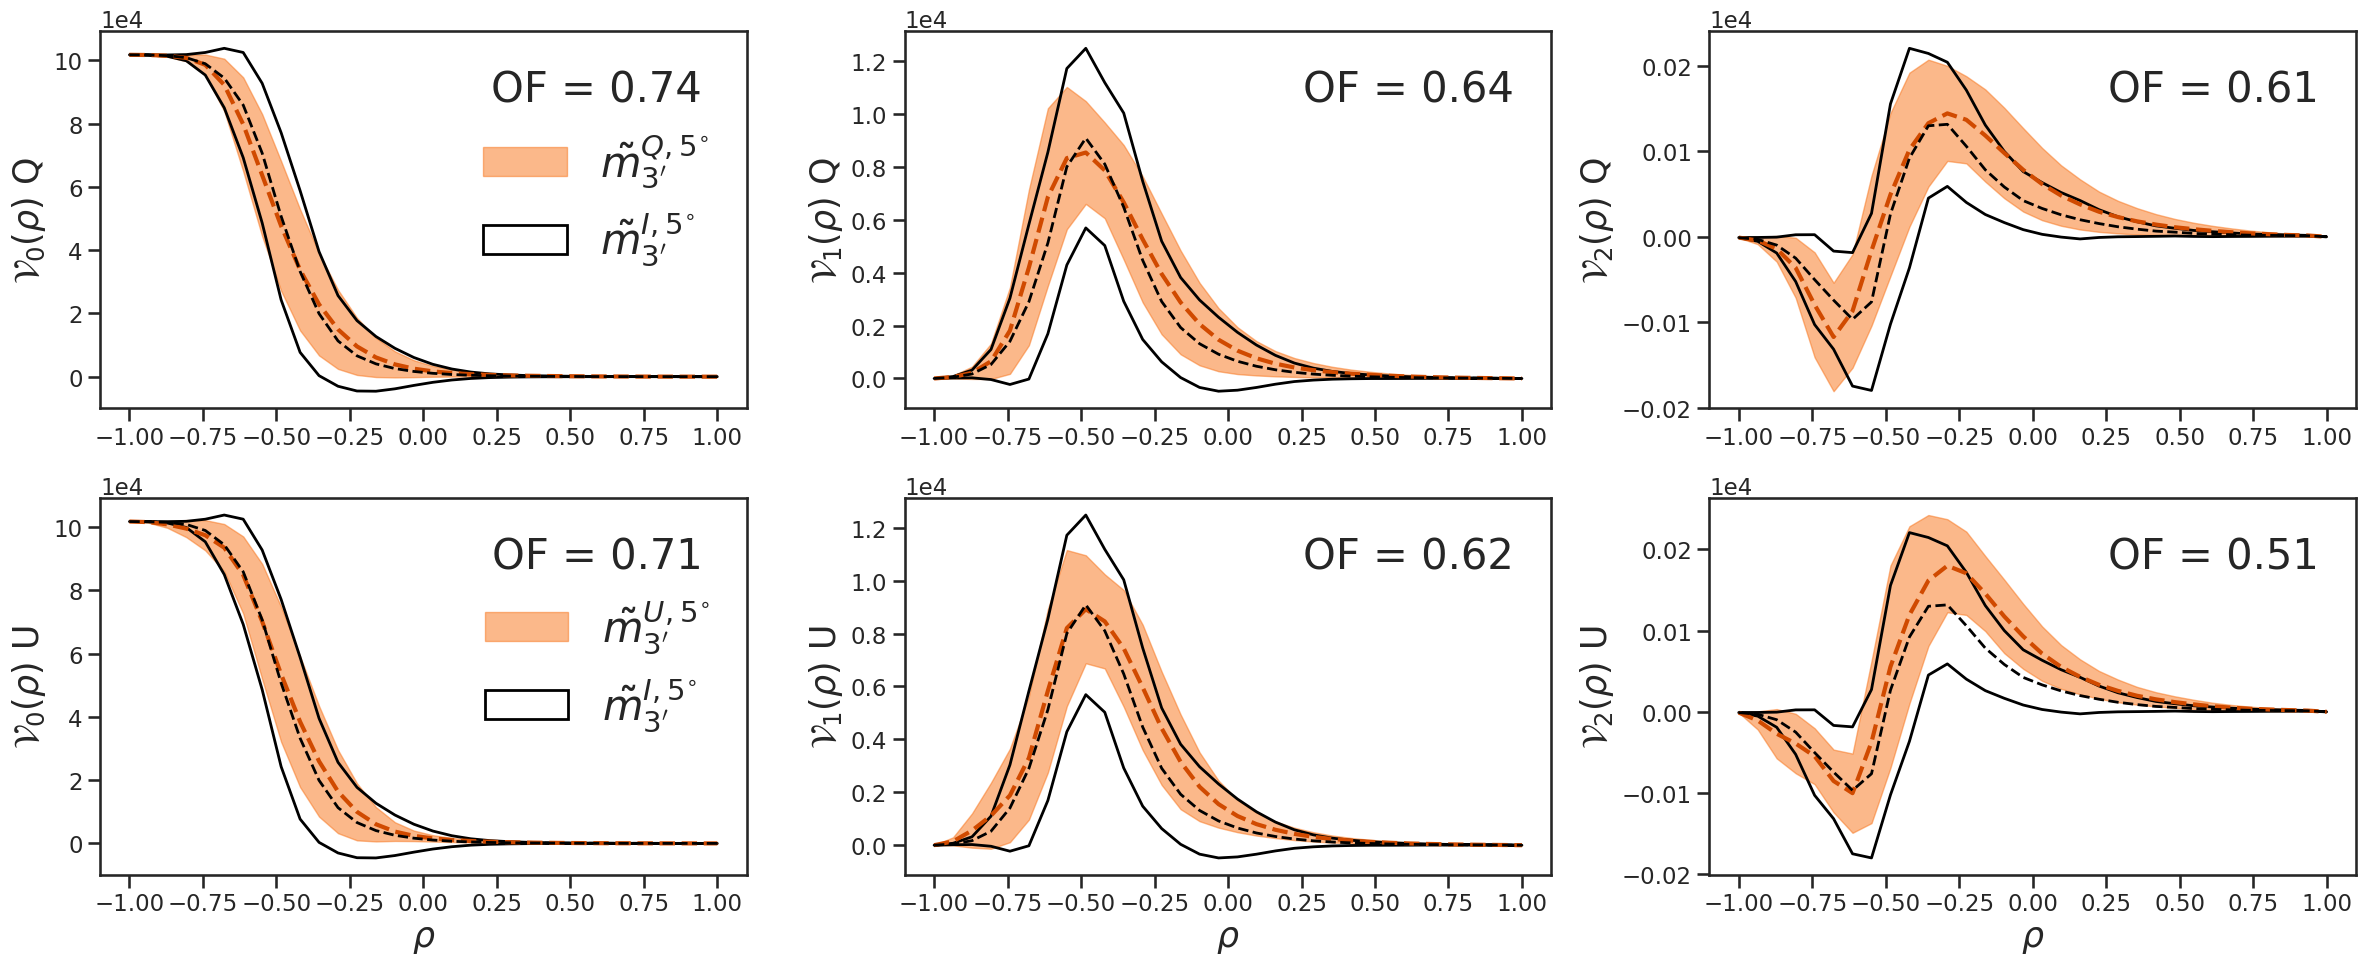

In [6]:
test = output3.plot_MF(patch_N = 5, savedir=False)